# Unit Commitment

The Unit Commitment problem is a fundamental problem in power systems. It is the scheduling of generators, in other words the decision if a unit is on or off for any given time in the planning horizon. The Unit Commitment includes constraints like capacity limits, ramping limitations, minimum runtimes, and minimum downtimes. The Security Constraint Unit Commitment also includes the system reserve requirements and network constraints.

**1. Load packages and useful definitions**
   - We are using the gurobipy package to formulate a mathematical model and solve it. 

In [4]:
# import required packages

import pandas as pd
import numpy as np
import math

import gurobipy as gp
from gurobipy import GRB

import matplotlib.pyplot as plt

In [5]:
# some helpful definitions

gen_colors = {
    "Hydro": "#1f78b4",  # Deep Blue
    "Nuclear": "#e31a1c",  # Red
    "Coal": "#8b4513",  # Dark Brown
    "Gas CC": "#8e44ad",  # Medium Purple
    "Gas CT": "#a569bd",  # Light Purple
    "Oil CT": "#4d4d4d",  # Dark Gray
    "Wind": "#6baed6",  # Light Sky Blue
    "PV": "#ff7f00",  # Bright Orange
    "Storage": "#33a02c" # Green
}

def print_gp_status(m):
    status = m.Status
    if status == GRB.OPTIMAL:
        print("The model is optimal.")
    elif status == GRB.INFEASIBLE:
        print("The model is infeasible.")
    elif status == GRB.UNBOUNDED:
        print("The model is unbounded.")
    else:
        print(f"Optimization ended with status {status}.")
    print()
    return status

**2. Read and prepare data**
- The data we have are the various generator units.
- It includes the unit type and the corresponding cost, startup cost and variable cost.
- It also includes technical limitations like the installed amount, minimum generation levels, ramping rates, minimum down time and minimum up time (minimum run time). 

In [6]:
# read the data
data_file = "ts_and_gen_scuc.xlsx"
load_and_res_data = pd.read_excel(data_file, sheet_name=0)
gen_data = pd.read_excel(data_file, sheet_name=1)

In [7]:
# inspect the data
gen_data.head()

,Gen ID,Unit Type,SU cost $,Variable Cost USD/MWh,Installed in MW,PMin in MW,Ramp Rate in MW /hr,Min Down Time Hr,Min Up Time Hr,SR eligible
0,N1,Nuclear,70.0,3,400,300,300,48,24,0
1,N2,Nuclear,70.0,3,400,300,300,48,24,0
2,O1,Oil CT,0.5,50,40,10,50,1,1,1
3,O2,Oil CT,0.5,50,40,10,50,1,1,1
4,O3,Oil CT,0.5,50,40,10,50,1,1,1


In [8]:
# prepare data for scuc

# generator data
gen_id = gen_data['Gen ID'].to_numpy()
gen_type = gen_data['Unit Type'].to_numpy()
mc = gen_data['Variable Cost USD/MWh'].to_numpy()
Pmax = gen_data['Installed in MW'].to_numpy()
R60 = gen_data['Ramp Rate in MW /hr'].to_numpy()
# new:
su_cost = gen_data['SU cost $'].to_numpy()
Pmin = gen_data['PMin in MW'].to_numpy()
min_uptime = gen_data['Min Up Time Hr'].to_numpy()
min_downtime = gen_data['Min Down Time Hr'].to_numpy()
sr_elig = gen_data['SR eligible'].to_numpy()

n_gen = len(gen_id)

# load data
load = load_and_res_data['Load MW'].to_numpy()
wind = load_and_res_data['Wind MW'].to_numpy()
pv = load_and_res_data['PV MW'].to_numpy()
n_t = len(load)

**3. Inspect data**
- We can see the very typical duck curve (area between load and net-load looks like a duck). The net load is the load subtracted by RES production (in this case Wind and PV).

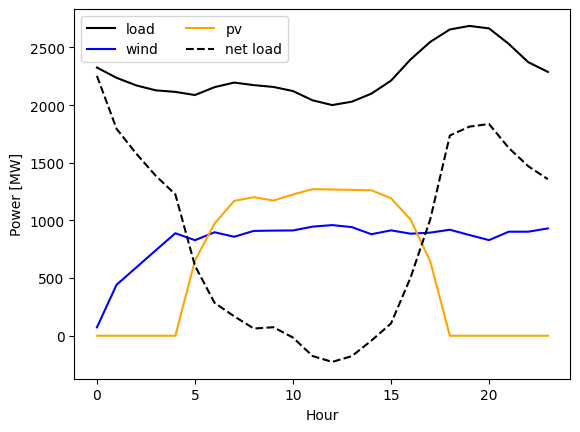

In [9]:
# inspect the data

fig, ax = plt.subplots(1,1)
ax.plot(load, label="load", color="black")
ax.plot(wind, label="wind", color="blue")
ax.plot(pv, label="pv", color="orange")
ax.plot(load-wind-pv, label="net load", color="black", ls="--")
ax.set_ylabel("Power [MW]")
ax.set_xlabel("Hour")
ax.legend(ncols=2);

**4. Define mathematical model (SCUC with reserves)**

**Objective function:**
- Minimize the sum of cost of generation _$C_t^{\text{gen}}$_ and unit commitment _$C_t^{\text{uc}}$_ over time _T_.

**Sets:**
- _$\mathcal{G}^{\rm S}$_ Set of generators with spinning reserve eligibility.
  
**Decision variables:**
- _$p_{i,t}^{\text{c}}$_ production of conventional generator _i_ in _t_.
- _$p_{i,t}^{\text{w}}$_ production of wind generator _i_ in _t_.
- _$p_{i,t}^{\text{pv}}$_ production of PV _i_ in _t_.
- _$r^{\rm s}_{i,t}$_ spinning reserve of _i_ in _t_.
- _$r^{\rm ns}_{i,t}$_ non-spinning reserve in _i_ in _t_.

**Binary decision variables:**
- _$u_{i,t}$_ on/off status indicator of unit _i_ in _t_.
- _$v_{i,t}$_ start-up indicator of unit _i_ in _t_ ( can be relaxed to be bound between 0 and 1 as long as _$u_{i,t}$_ is binary).
- _$w_{i,t}$_ shut-down indicator of unit _i_ in _t_ ( can be relaxed to be bound between 0 and 1 as long as _$u_{i,t}$_ is binary).

**SCUC Constraints:**
- Generation cost _$C_t^{\text{gen}}$_ is equal to the cost function _$c_i(p^{\text{c}}_{i,t})$_ 
- Unit commitment cost _$C_t^{\text{curt}}$_ occur for each start-up event indicated by _$v_{i,t}$_ with cost _$c^{\rm su}_i$_ and for each shut-down event indicated by _$w_{i,t}$_ with cost _$c^{\rm sd}_i$_.
- Energy balance constraint: The sum of generation needs to equal the demand _$D_t$_ in each _t_.
- Generator capacity constraint: Each generators output needs to be within their respective lower and upper limits if the unit is on, whcih is indicated by _$u_{i,t} = 1$_.
- Minimum up and run time constraints: After a startup or shutdown event the generator is required to stay on/off given by the _DT_ and _UT_.
- Ramping constraints: Conventional generators have ramping constraints, which limit how much their generation _$p_{i,t}^{\text{c}}$_ can change up or down from one time step to the next. It is limit by _$R_i^{\text{60}}$_ and it includes the required ramping limits for startup and shutdown events.

\begin{align}
\min \quad 
    & \sum_{t=1}^T \big(C_t^{\rm gen} + C_t^{\rm uc} \big)\\
\text{s.t.} \quad 
    & C_t^{\rm gen} = \sum_{i\in[G]} c_i(p^{\rm c}_{i,t}) && \forall t \in [T] \\
    & C_t^{\rm uc} = \sum_{i\in[G]}\big(c^{\rm su}_i v_{i,t} + c^{\rm sd}_i w_{i,t} \big) && \forall t \in [T]  \\
    & \sum_{i\in[G]} p_{i,t}^{\rm c} + \sum_{i\in[W]} p_{i,t}^{\rm w} + \sum_{i\in[PV]} p_{i,t}^{\rm pv} = D_t && \forall t \in [T]  \\
    & \underline{P}_{i}u_{i,t}  \le p_{i,t}^{\rm c} \le \overline{P}_{i}u_{i,t} && \forall i \in [G],t \in [T]  \\
    & \sum_{s=t-(UT_i-1)}^t v_{i,s} \leq u_{i,t} && \forall i \in [G],t \in [T]  \\
    & \sum_{s=t-(DT_i-1)}^t w_{i,s} \leq 1-u_{i,t} && \forall i \in [G],t \in [T]  \\
    & v_{i,t} - w_{i,t} = u_{i,t} - u_{i,t-1} && \forall i \in [G],t \in [T]   \\
    & p_{i,t}^{\rm c} - p_{i,t-1}^{\rm c}  \le R_i^{\rm 60} + v_{i,t}\underline{P}_i && \forall i \in [G],t \in [T]  \\
    & p_{i,t-1}^{\rm c} - p_{i,t}^{\rm c}  \le R_i^{\rm 60} + w_{i,t}\underline{P}_i && \forall i \in [G],t \in [T]  \\
    & u_{i,t}\in\{0,1\} && \forall i \in [G],t \in [T]  \\
    & 0 \le v_{i,t}, w_{i,t} \le 1 && \forall i \in [G], t \in [T]  
\end{align}
**Reserve constraints:**
- Generators cannot offer reserves beyond their output levels.
- Only some generators are eligible to offer spinning reserves.
- Reserves need to be greater or eqaul to the largest contributing generator.
- Reserves need to be greater or equal to the reserve requirements level _$r^{\rm req}_t$_.
- Half of reserve requirement _$r^{\rm req}_t$_ needs to be covered by at least 50\% spinning reserves.

\begin{align}
    & p_{i,t} + r^{\rm s}_{i,t} \le \overline{P}_i u_{i,t} && \forall i \in [G],t \in [T]  \\
    & p_{i,t} + r^{\rm s}_{i,t} + r^{\rm ns}_{i,t} \le \overline{P}_i && \forall i \in [G],t \in [T]  \\
    & r_{i,t}^{\rm s} = 0 && \forall i \in [G]\setminus \mathcal{G}^{\rm S}, t \in [T]  \\
    & r^{\rm req}_t \ge p_{i,t} && \forall t \in [T]  \\
    & \sum_{i\in[G]} (r^{\rm s}_{i,t} + r^{\rm ns}_{i,t}) \ge r^{\rm req}_t && \forall t \in [T]  \\
    & \sum_{i\in[G]} r^{\rm s}_{i,t} \ge 0.5 r^{\rm req}_t && \forall t \in [T] 
\end{align}


The model is optimal.

Objective value 188.18 k$.

A total of 1475.71 MWh wind were curtailed.
A total of 2866.40 MWh PV were curtailed.


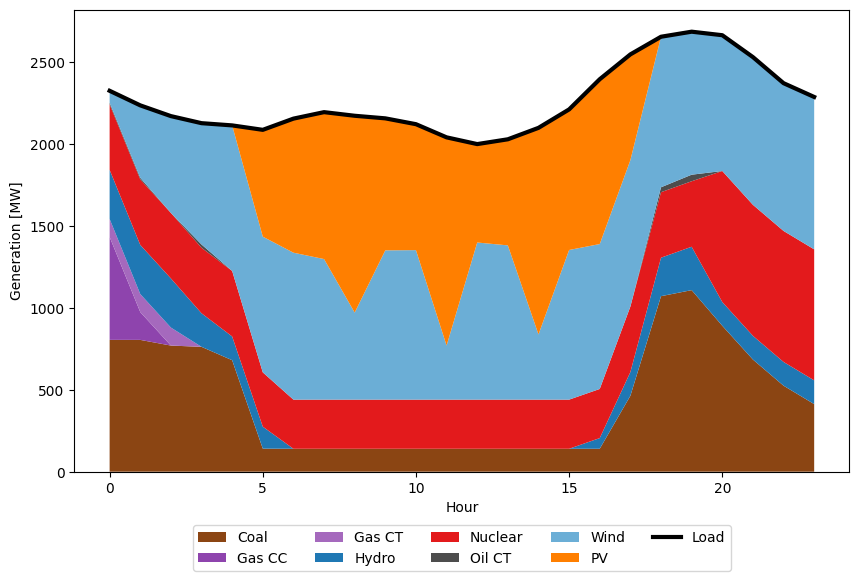

In [18]:
# SCUC Model

# some additonal parameters
wind_curt_pen = 0 # $/MWh
pv_curt_pen = 0 # $/MWh

# write the SCUC model
m = gp.Model()
m.setParam("OutputFlag", 0)

# add variables
p = m.addVars(n_gen, n_t, lb=0, ub=GRB.INFINITY, name="p")
u = m.addVars(n_gen, n_t, vtype=GRB.BINARY, name="u") # commitment indicator
v = m.addVars(n_gen, n_t, lb=0, ub=1, name="v") # start-up indicator
w = m.addVars(n_gen, n_t, lb=0, ub=1, name="w") # shut-down indicator
p_wind = m.addVars(n_t, lb=0, ub=GRB.INFINITY, name="p_wind")
p_pv = m.addVars(n_t, lb=0, ub=GRB.INFINITY, name="p_pv")
r_req = m.addVars(n_t, lb=0, ub=GRB.INFINITY, name="r_req")
p_rs = m.addVars(n_gen, n_t, lb=0, ub=GRB.INFINITY, name="p_rs") # spinning reserve
p_rns = m.addVars(n_gen, n_t, lb=0, ub=GRB.INFINITY, name="p_rns") # non-spinning reserve


# energy balance
m.addConstrs((sum(p[i,t] for i in range(n_gen)) + p_wind[t] + p_pv[t] == load[t] for t in range(n_t)), name="energy_balance")

# generator constraints
for t in range(n_t):
    for i in range(n_gen):
        # maximum generation
        m.addConstr(p[i,t] + p_rs[i,t] <= Pmax[i]*u[i,t]) # spinning reserve can be provided only from "on" generators
        m.addConstr(p[i,t] + p_rs[i,t] + p_rns[i,t] <= Pmax[i]) # non-spiining reserve can be provided also from "off" generators
        m.addConstr(p[i,t] >= Pmin[i]*u[i,t])
        # reserve eligibility
        if sr_elig[i]==0:
            m.addConstr(p_rs[i,t] == 0)
        # ramping
        if t>0:
            # when generators are switching on or off the output change may be larger than the ramp
            # limit if the ramp limit is smaller than the minimum production
            m.addConstr(p[i,t] - p[i,t-1] <= R60[i] + v[i,t]*Pmin[i])
            m.addConstr(p[i,t-1] - p[i,t] <= R60[i] + w[i,t]*Pmin[i])
        # unit commitment constraints
        # constraints on minimum up and downtime
        ut = max(t-(math.ceil(min_uptime[i])-1), 0) 
        dt = max(t-(math.ceil(min_downtime[i])-1), 0)
        m.addConstr(sum(v[i, s] for s in range(ut,t)) <= u[i,t])
        m.addConstr(sum(w[i, s] for s in range(dt,t)) <= 1 - u[i,t])
        # start-up and shut-down constraints
        if t>0:
            m.addConstr(v[i,t] - w[i,t] == u[i,t] - u[i,t-1])
        else:
            # First timestep has no ramping constraints, i.e. system can jump-start
            m.addConstr(v[t,i] - w[t,i] == u[t,i])

# RES constraints
for t in range(n_t):
    m.addConstr(p_wind[t] <= wind[t])
    m.addConstr(p_pv[t] <= pv[t])

# reserve constraints
for t in range(n_t):
    # reserve must cover at least the largest production of a single generator
    m.addConstrs(r_req[t] >= p[i,t] for i in range(n_gen))
    m.addConstr(sum(p_rs[i,t] + p_rns[i,t] for i in range(n_gen)) >= r_req[t])
    # at least 50% of reserve must be spinning reserve
    m.addConstr(sum(p_rs[i,t]for i in range(n_gen)) >= 0.5*r_req[t])

# objective
gen_cost = sum(sum(mc[i]*p[i,t] for i in range(n_gen)) for t in range(n_t))
curt_cost = sum((pv[t]-p_pv[t])*pv_curt_pen + (wind[t]-p_wind[t])*wind_curt_pen for t in range(n_t))
startup_cost = sum(v[i,t]*su_cost[i] for i in range(n_gen) for t in range(n_t))
m.setObjective(
    gen_cost + curt_cost + startup_cost, GRB.MINIMIZE
)

# run
m.optimize()

# Check the status of the solver
print_gp_status(m)

# Objective value
objective = m.ObjVal
print(f"Objective value {objective/1e3:.2f} k$.\n")

# production plot
p_res = {type: np.array([m.getVarByName(f"p[{i},{t}]").X for t in range(n_t)]) for (i,type) in enumerate(gen_id)}
p_res['Wind'] = np.array([m.getVarByName(f"p_wind[{t}]").X for t in range(n_t)])
p_res['PV'] = np.array([m.getVarByName(f"p_pv[{t}]").X for t in range(n_t)])

#curtailment
wind_curt_res = wind - np.array(p_res['Wind'])
pv_curt_res = pv - np.array(p_res['PV'])
print(f"A total of {sum(wind_curt_res):.2f} MWh wind were curtailed.")
print(f"A total of {sum(pv_curt_res):.2f} MWh PV were curtailed.")

# let's aggregate generator production by generator type

# list of unique generator types
gen_type_unique = np.unique(gen_type)
# map of generator types to generators
gens_per_type = {gtu: [i for i,gt in enumerate(gen_type) if gt==gtu] for gtu in gen_type_unique}
# sum the respective production
p_res_type = {gtu: sum([p_res[gi] for i,gi in enumerate(gen_id) if i in genst]) for gtu,genst in gens_per_type.items()}
# add wind and PV results
p_res_type['Wind'] = np.array([m.getVarByName(f"p_wind[{t}]").X for t in range(n_t)])
p_res_type['PV'] = np.array([m.getVarByName(f"p_pv[{t}]").X for t in range(n_t)])


# plot of aggregated production
fig, ax = plt.subplots(1,1)
fig.set_size_inches(10,6)
x = np.arange(24)
color_list = [gen_colors[g] for g in list(p_res_type.keys())]
ax.stackplot(x, list(p_res_type.values()), labels=list(p_res_type.keys()), colors=color_list);
ax.plot(load, linewidth=3, color='black', label='Load')
ax.set_xlabel("Hour")
ax.set_ylabel("Generation [MW]")
ax.legend(ncols=5, loc="lower center", bbox_to_anchor=(0.5, -0.23));

**5. Prices from SCUC**
- In a Economic Dispatch (ED) problem, prices can be drawn by taking the dual variable of the energy balance constraint.
- In the case of a SCUC computing the dual of the energy balance will fail because the model is a Mixed-Integer Problem (MIP).
- This means the following block will return a error message:

In [17]:

system_price = m.getConstrByName(f"energy_balance[{1}]").Pi

AttributeError: Unable to retrieve attribute 'Pi'

**A workaround is to first retrieve the unit commitmennt decisions and fix them in the SCUC model, turning it into a Linear Programming (LP) problem**

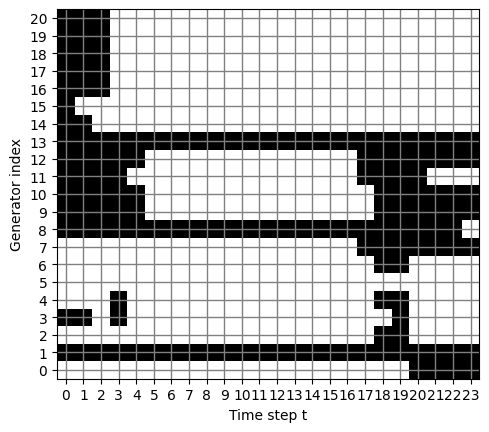

In [19]:
# let's retrieve and save the unit commitment decisions and plot them

u_opt = np.array([[u[i,t].X for t in range(n_t)] for i in range(n_gen)])

# Plot the grid
plt.imshow(u_opt, cmap='gray_r', interpolation='nearest', origin='lower')
plt.xticks(ticks=np.arange(u_opt.shape[1]), labels=np.arange(u_opt.shape[1]))
plt.yticks(ticks=np.arange(u_opt.shape[0]), labels=np.arange(u_opt.shape[0]))
plt.grid(color='gray', linestyle='-', linewidth=1)
plt.ylabel("Generator index")
plt.xlabel("Time step t")

plt.show()

**Now re-run the model with the commitment-decisions fixed:**

The model is optimal.

Objective value 188.16 k$.

A total of 2454.41 MWh wind were curtailed.
A total of 1887.70 MWh PV were curtailed.


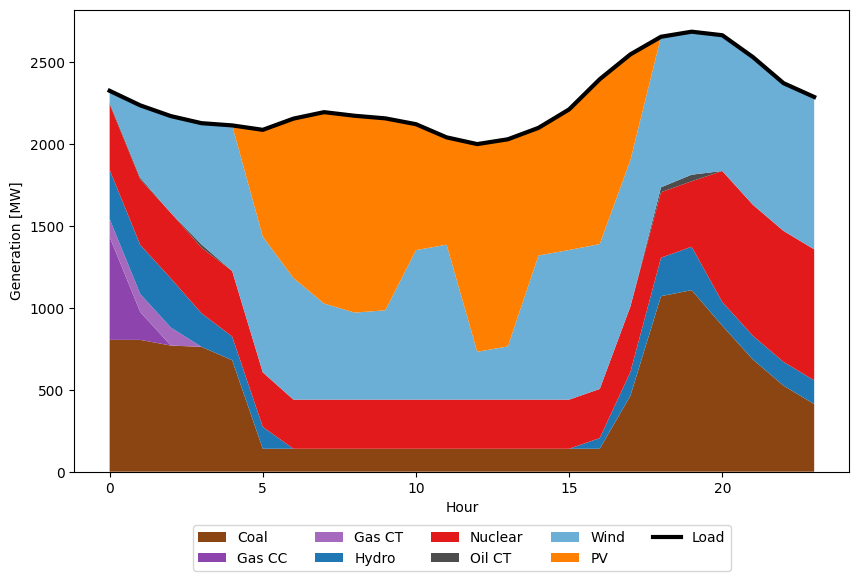

In [ ]:
# create a version of the model with fixed integer variables

m_fixed = m.fixed() # requires m to contain an optimal solution

# run the fixed version
m_fixed.optimize()

# Check the status of the solver
print_gp_status(m)

# Objective value
objective = m_fixed.ObjVal
print(f"Objective value {objective/1e3:.2f} k$.\n")

# production plot
p_res = {type: np.array([m_fixed.getVarByName(f"p[{i},{t}]").X for t in range(n_t)]) for (i,type) in enumerate(gen_id)}
p_res['Wind'] = np.array([m_fixed.getVarByName(f"p_wind[{t}]").X for t in range(n_t)])
p_res['PV'] = np.array([m_fixed.getVarByName(f"p_pv[{t}]").X for t in range(n_t)])

#curtailment
wind_curt_res = wind - np.array(p_res['Wind'])
pv_curt_res = pv - np.array(p_res['PV'])
print(f"A total of {sum(wind_curt_res):.2f} MWh wind were curtailed.")
print(f"A total of {sum(pv_curt_res):.2f} MWh PV were curtailed.")

# let's aggregate generator production by generator type

# list of unique generator types
gen_type_unique = np.unique(gen_type)
# map of generator types to generators
gens_per_type = {gtu: [i for i,gt in enumerate(gen_type) if gt==gtu] for gtu in gen_type_unique}
# sum the respective production
p_res_type = {gtu: sum([p_res[gi] for i,gi in enumerate(gen_id) if i in genst]) for gtu,genst in gens_per_type.items()}
# add wind and PV results
p_res_type['Wind'] = np.array([m_fixed.getVarByName(f"p_wind[{t}]").X for t in range(n_t)])
p_res_type['PV'] = np.array([m_fixed.getVarByName(f"p_pv[{t}]").X for t in range(n_t)])


# plot of aggregated production
fig, ax = plt.subplots(1,1)
fig.set_size_inches(10,6)
x = np.arange(24)
color_list = [gen_colors[g] for g in list(p_res_type.keys())]
ax.stackplot(x, list(p_res_type.values()), labels=list(p_res_type.keys()), colors=color_list);
ax.plot(load, linewidth=3, color='black', label='Load')
ax.set_xlabel("Hour")
ax.set_ylabel("Generation [MW]")
ax.legend(ncols=5, loc="lower center", bbox_to_anchor=(0.5, -0.23));

**Now lets get prices:**

In [21]:
system_price = [m.getConstrByName(f"energy_balance[{t}]").Pi for t in range(n_t)]
print(system_price)

[25.0, 14.0, 14.0, 14.0, 12.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 10.0, 14.0, 14.0, 12.0, 10.0, 10.0, 10.0]


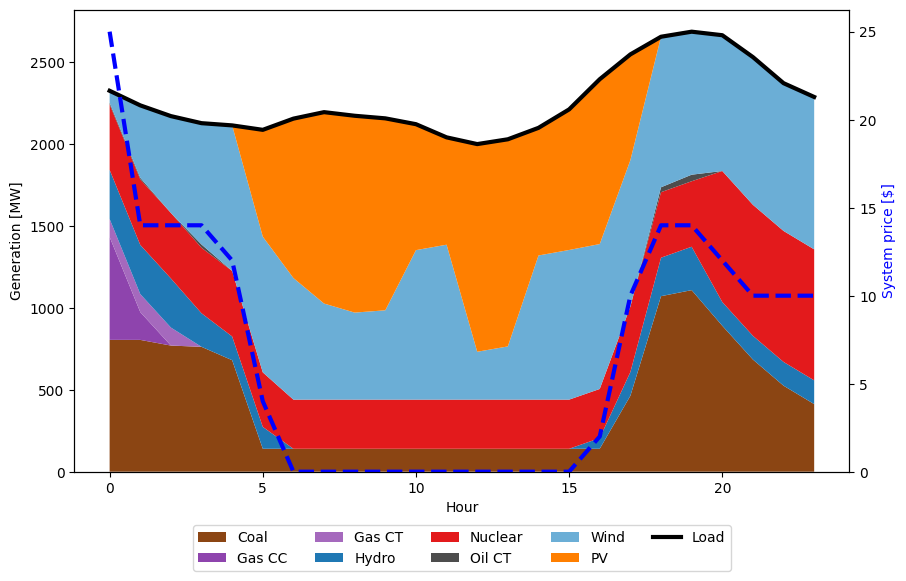

In [22]:
# plot production with price

fig, ax = plt.subplots(1,1)
fig.set_size_inches(10,6)
x = np.arange(24)
color_list = [gen_colors[g] for g in list(p_res_type.keys())]
ax.stackplot(x, list(p_res_type.values()), labels=list(p_res_type.keys()), colors=color_list);
ax.plot(load, linewidth=3, color='black', label='Load')
ax2 = ax.twinx() 
ax2.plot(system_price, color='blue', linewidth=3, ls="--", label="Price")
ax2.set_ylim(0)
ax2.set_ylabel("System price [$]", color="blue")
ax.set_xlabel("Hour")
ax.set_ylabel("Generation [MW]")
ax.legend(ncols=5, loc="lower center", bbox_to_anchor=(0.5, -0.23));

**6. Let us add an ideal storage to the SCUC model**
- An ideal storage does not consider charging and discharging efficiencies.

**Added decision variables:**
- _$p_t^{\rm ch}$_ charging in _t_.
- _$p_t^{\rm dis}$_ discharging in _t_.
- _$e_t$_ State of Charge (SoC) in _t_.

**Battery constraints:**
- Battery energy balance constraint: battery SoC is equal to previous SoC including all charging and discharging activities.
- Storage capacity constraint: battery SoC is limited by lower and upper bounds.
- Power capacity constraint: charging and discharging is limited by the power capacity.
- Bilinear feasibility constraint: disallowing charging and discharging in the same time _t_.

\begin{align}
    &e_t = e_{t-1} + p_t^{\rm ch} \eta^{\rm ch} - p_t^{\rm dis} \frac{1}{\eta^{\rm dis}} \\
    & \underline{E} \le e_t \le \overline{E} && \forall t \in [T] \\
    & 0 \leq p_t^{\rm ch} \le \overline{P}^{\rm ess} && \forall t \in [T] \\
    & 0 \leq p_t^{\rm dis} \le \overline{P}^{\rm ess} && \forall t \in [T] \\
    & p_t^{\rm ch} p_t^{\rm dis} = 0 && \forall t \in [T]
\end{align}

The bilinear feasibility constraint can reformulated using a binary variable indicating charging status:

\begin{align}
    & p_t^{\rm ch} \le \overline{P}^{\rm ess}u^{\rm ch} && \forall t \in [T] \\
    & p_t^{\rm dis} \le \overline{P}^{\rm ess}(1-u^{\rm ch}) && \forall t \in [T] \\
    & u^{\rm ch} \in \{0,1\} && \forall t \in [T]
\end{align}


In [ ]:

# some additonal parameters
wind_curt_pen = 0 # $/MWh
pv_curt_pen = 0 # $/MWh

# define the storage
ess_Emin = 0
ess_Emax = 1000 # MWh
ess_E0 = 250 # assume storage is half full at start of day
ess_Etarget = ess_E0 # assume at end of day storage should be half full again for next day
ess_pmax = 200 # MW

# write the SCUC model
m = gp.Model()
m.setParam("OutputFlag", 0)

# add variables
p = m.addVars(n_gen, n_t, lb=0, ub=GRB.INFINITY, name="p")
u = m.addVars(n_gen, n_t, vtype=GRB.BINARY, name="u") # commitment indicator
v = m.addVars(n_gen, n_t, lb=0, ub=1, name="v") # start-up indicator
w = m.addVars(n_gen, n_t, lb=0, ub=1, name="w") # shut-down indicator
p_wind = m.addVars(n_t, lb=0, ub=GRB.INFINITY, name="p_wind")
p_pv = m.addVars(n_t, lb=0, ub=GRB.INFINITY, name="p_pv")
r_req = m.addVars(n_t, lb=0, ub=GRB.INFINITY, name="r_req")
p_rs = m.addVars(n_gen, n_t, lb=0, ub=GRB.INFINITY, name="p_rs") # spinning reserve
p_rns = m.addVars(n_gen, n_t, lb=0, ub=GRB.INFINITY, name="p_rns") # non-spinning reserve
p_charge = m.addVars(n_t, lb=0, ub=GRB.INFINITY, name="p_charge") # storage charging
p_disch = m.addVars(n_t, lb=0, ub=GRB.INFINITY, name="p_disch") # storage discharging
e = m.addVars(n_t, lb=0, ub=GRB.INFINITY, name="e") # energy in storage

# energy balance
m.addConstrs((sum(p[i,t] for i in range(n_gen)) + p_wind[t] + p_pv[t] + p_disch[t] - p_charge[t] == load[t] for t in range(n_t)), name="energy_balance")

# generator constraints
for t in range(n_t):
    for i in range(n_gen):
        # maximum generation
        m.addConstr(p[i,t] + p_rs[i,t] <= Pmax[i]*u[i,t]) # spinning reserve can be provided only from "on" generators
        m.addConstr(p[i,t] + p_rs[i,t] + p_rns[i,t] <= Pmax[i]) # non-spinning reserve can be provided also from "off" generators
        m.addConstr(p[i,t] >= Pmin[i]*u[i,t])
        # reserve eligibility
        if sr_elig[i]==0:
            m.addConstr(p_rs[i,t] == 0)
        # ramping
        if t>0:
            # when generators are switching on or off the output change may be larger than the ramp
            # limit if the ramp limit is smaller than the minimum production
            m.addConstr(p[i,t] - p[i,t-1] <= R60[i] + v[i,t]*Pmin[i])
            m.addConstr(p[i,t-1] - p[i,t] <= R60[i] + w[i,t]*Pmin[i])
        # unit commitment constraints
        # constraints on minimum up and downtime
        ut = max(t-(math.ceil(min_uptime[i])-1), 0) 
        dt = max(t-(math.ceil(min_downtime[i])-1), 0)
        m.addConstr(sum(v[i, s] for s in range(ut,t)) <= u[i,t])
        m.addConstr(sum(w[i, s] for s in range(dt,t)) <= 1 - u[i,t])
        # start-up and shut-down constraints
        if t>0:
            m.addConstr(v[i,t] - w[i,t] == u[i,t] - u[i,t-1])
        else:
            # First timestep has no ramping constraints, i.e. system can jump-start
            m.addConstr(v[t,i] - w[t,i] == u[t,i])

# storage constraints
for t in range(n_t):
    m.addConstr(p_charge[t] <= ess_pmax)
    m.addConstr(p_disch[t] <= ess_pmax)
    m.addConstr(e[t] >= ess_Emin)
    m.addConstr(e[t] <= ess_Emax)
    if t>0:
        m.addConstr(e[t] == e[t-1] + p_charge[t] - p_disch[t])
m.addConstr(e[0] == ess_E0)
m.addConstr(e[n_t-1] == ess_Etarget)
        
# RES constraints
for t in range(n_t):
    m.addConstr(p_wind[t] <= wind[t])
    m.addConstr(p_pv[t] <= pv[t])

# reserve constraints
for t in range(n_t):
    # reserve must cover at least the largest production of a single generator
    m.addConstrs(r_req[t] >= p[i,t] for i in range(n_gen))
    m.addConstr(sum(p_rs[i,t] + p_rns[i,t] for i in range(n_gen)) >= r_req[t])
    # at least 50% of reserve must be spinning reserve
    m.addConstr(sum(p_rs[i,t]for i in range(n_gen)) >= 0.5*r_req[t])

# objective
gen_cost = sum(sum(mc[i]*p[i,t] for i in range(n_gen)) for t in range(n_t))
curt_cost = sum((pv[t]-p_pv[t])*pv_curt_pen + (wind[t]-p_wind[t])*wind_curt_pen for t in range(n_t))
startup_cost = sum(v[i,t]*su_cost[i] for i in range(n_gen) for t in range(n_t))
m.setObjective(
    gen_cost + curt_cost + startup_cost, GRB.MINIMIZE
)

# run
m.optimize()

# Check the status of the solver
print_gp_status(m)

# Objective value
objective = m.ObjVal
print(f"Objective value {objective/1e3:.2f} k$.\n")

# prodcution plot
p_res = {type: np.array([m.getVarByName(f"p[{i},{t}]").X for t in range(n_t)]) for (i,type) in enumerate(gen_id)}
p_res['Wind'] = np.array([m.getVarByName(f"p_wind[{t}]").X for t in range(n_t)])
p_res['PV'] = np.array([m.getVarByName(f"p_pv[{t}]").X for t in range(n_t)])

#curtailment
wind_curt_res = wind - np.array(p_res['Wind'])
pv_curt_res = pv - np.array(p_res['PV'])
print(f"A total of {sum(wind_curt_res):.2f} MWh wind were curtailed.")
print(f"A total of {sum(pv_curt_res):.2f} MWh PV were curtailed.")

# let's aggregate generator production by generator type

# list of unique generator types
gen_type_unique = np.unique(gen_type)
# map of generator types to generators
gens_per_type = {gtu: [i for i,gt in enumerate(gen_type) if gt==gtu] for gtu in gen_type_unique}
# sum the respective production
p_res_type = {gtu: sum([p_res[gi] for i,gi in enumerate(gen_id) if i in genst]) for gtu,genst in gens_per_type.items()}
# add wind and PV results
p_res_type['Wind'] = np.array([m.getVarByName(f"p_wind[{t}]").X for t in range(n_t)])
p_res_type['PV'] = np.array([m.getVarByName(f"p_pv[{t}]").X for t in range(n_t)])
# add storage results
p_res_type['Storage'] = np.array([m.getVarByName(f"p_disch[{t}]").X for t in range(n_t)]) - np.array([m.getVarByName(f"p_charge[{t}]").X for t in range(n_t)])

# plot of aggregated production
fig, ax = plt.subplots(1,1)
fig.set_size_inches(10,6)
x = np.arange(24)
color_list = [gen_colors[g] for g in list(p_res_type.keys())]
ax.stackplot(x, list(p_res_type.values()), labels=list(p_res_type.keys()), colors=color_list);
ax.plot(load, linewidth=3, color='black', label='Load')
ax.set_xlabel("Hour")
ax.set_ylabel("Generation [MW]")
ax.legend(ncols=5, loc="lower center", bbox_to_anchor=(0.5, -0.23));